In [189]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May 27 22:15:13 2022

@author: rodrigo
"""

#Cargando librerías 
import importlib

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import os
import sys
import itertools as it

from geneticalgorithm import geneticalgorithm as ga

root = os.getcwd() + "/.."

sys.path.insert(0, root)

import src.positioning_sensors as ps
importlib.reload(ps)

import src.network_fitness as netfit
importlib.reload(netfit)

import src.manageExperiments as me
importlib.reload(me)

import config.config as cfg
importlib.reload(cfg)


#read_global_variables

plt.style.use("ggplot")


fn = "linz_with_init_net_exp_2.txt"
setup = me.readConfigFile(fn)

#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"] + setup["input_ntli"]
niveles = setup["folder_input"] + setup["input_evm"]
sigma_y = setup['filterg_sy']
sigma_x = setup['filterg_sx']
sigma = [sigma_y,sigma_x]

#Loading precalculated local and directed empirical variograms
path2output_semivars = (cfg.experiment 
          + setup["experiment_id"]
          + setup["folder_semivariances"]
          + setup["output_semivariances"] 
                       )


filesv = path2output_semivars + ".csv"
filesvmask = path2output_semivars + "mask.csv"

path2optimum_values_file = (cfg.experiment 
                           + setup["experiment_id"] 
                           + setup["folder_output"] 
                           )

saveOptimumValuesTofile = (path2optimum_values_file
                           + setup["output_values"]
                          )

saveArgsTofile = (path2optimum_values_file
                  + setup["output_args"]
                 )

data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)
variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])


#NLTI: luminance
#luminance = ps.readIMG(cfg.data + ilumina)

ilumina = cfg.data + setup["folder_input"] + setup["input_ntli"]
niveles = cfg.data + setup["folder_input"] + setup["input_evm"]

#NTLI: luminance
NTLI = ps.readIMG(ilumina)

from PIL import Image

**Leyendo archivo de configuración del experimento**

In [139]:
fn = "linz_with_init_net_exp_2.txt"

**This function creates the following experiment structure where the semivariance maps and results are saved**
```
linz_experiment_with_initial_positions_no2/
├── linz_with_init_net_exp_2.txt
├── results
└── semivariances
    ├── semivariance050512022.csv
    └── semivariance050512022mask.csv
```

In [140]:
setup = me.readConfigFile(fn)
for key in iter(setup):
    print(str(key)+":" ,setup[str(key)])

experiment_id: linz_experiment_with_initial_positions_no2/
folder_input: locations/linz/
folder_semivariances: semivariances/
folder_output: results/
input_ntli: world_atlas_linzn
input_evm: linz_prioridades
output_semivariances: semivariance050512022
output_values: optimum_values.csv
output_args: optimum_arguments.csv
desaturation_th: -1
neglect_values: -1
tolerance_distance: 0.5
tolerance_angle: 15
filterg_sx: 0.5
filterg_sy: 0.5
gaussian_mode: constant
init_fixed_net: [[39, 22], [35, 29], [34, 31], [34, 34], [36, 39]]
nsensors: [0, 1, 2, 3, 4, 5]
sensitivity_c: [1, 10, 20, 30, 40]
flatness_means_decrease: True
ga_params: {'max_num_iteration': 100, 'population_size': 2000, 'mutation_probability': 0.1, 'elit_ratio': 0.1, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': 500}


In [144]:
#cargamos imagenes en luminance e importance

print(cfg.data + setup["folder_input"] + setup["input_ntli"])
img1 = cfg.data + setup["folder_input"] + setup["input_ntli"]
img2 = cfg.data + setup["folder_input"] + setup["input_evm"]

NTLI = np.array(Image.open(img1))
FDNTLI = sp.ndimage.gaussian_filter(NTLI, sigma, mode = setup['gaussian_mode'])

EAM = ps.readIMG(img2, invert = True)

c = 1

../data/locations/linz/world_atlas_linzn


In [145]:
NTLI

array([[0.07265855, 0.07647815, 0.07460455, ..., 0.06149924, 0.05934204,
        0.05729267],
       [0.07628854, 0.0817636 , 0.08335751, ..., 0.06576104, 0.06295878,
        0.06072675],
       [0.07157964, 0.07126057, 0.07014456, ..., 0.07442533, 0.07050705,
        0.06687705],
       ...,
       [0.21172234, 0.23155227, 0.25653818, ..., 0.16743721, 0.16124935,
        0.15835474],
       [0.20950845, 0.23277245, 0.26307514, ..., 0.17331694, 0.16736256,
        0.16446161],
       [0.21419841, 0.23781224, 0.26740983, ..., 0.17809375, 0.17104147,
        0.16508079]], dtype=float32)

In [146]:
data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)

variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])

variograms = variogram_set.reshape(len(variogram_set),NTLI.shape[0],NTLI.shape[1])
variograms_m = variogram_set_m.reshape(len(variogram_set),NTLI.shape[0],NTLI.shape[1])

EAM = EAM/np.max(EAM)

In [147]:
coords = ps.get_coords(EAM==1)

allc = setup["sensitivity_c"]

alls = setup["nsensors"]

n_sensors = len(setup['init_fixed_net'])

network = setup['init_fixed_net']

network = np.array(network).flatten()

In [148]:
#r = 1
algorithm_parameters = setup["ga_params"]
algorithm_parameters["population_size"] = 200
algorithm_parameters["max_num_iteration"] = 500
algorithm_parameters["max_iteration_without_improv"] = 50

In [149]:
r = 1
sensitivity = ps.f5(FDNTLI, EAM, 1)

 W = i*a^(p)


In [150]:
aptitude = netfit.NetworkFitness(FDNTLI,
                                         EAM,
                                         sensitivity,
                                         variograms,
                                         variograms_m,
                                         coords,
                                         network,
                                         r,
                                         0.0,
                                        alpha = 0.0
                                    
                                    )

Selct cost functions: 
 'xor','max' or 'cover'


In [151]:
#Pbestcomb

#Pbestcomb_bidim = Pbestcomb.reshape(-1, 2)

#n = len(Pbestcomb_bidim)
#Z = np.zeros((n+1, FDNTLI.shape[0], FDNTLI.shape[1]))

In [152]:
#for ns in range(n):
#    ix = tuple(Pbestcomb_bidim[ns])
#    Z[ns + 1][ix] = FDNTLI[ix]

In [153]:
#np.sum(np.max(Z, axis = 0))/n

In [154]:
def averagePunctualLightPollution(X):
    
    
    P_bestcomb_bidim = X.reshape(-1, 2)
    
    n = len(P_bestcomb_bidim)
    
    Z = np.zeros((n+1, FDNTLI.shape[0], FDNTLI.shape[1]))
    
    for ns in range(n):
        ix = tuple(P_bestcomb_bidim[ns])
        Z[ns + 1][ix] = FDNTLI[ix]
        
    return np.sum(np.max(Z, axis = 0))/n
    
    


In [155]:
X = np.array([30, 34, 31, 36])

In [156]:
aptitude.getPuntualLightPollution(X)

0.19422375669563074

In [157]:
FDNTLI.shape

(62, 59)

In [158]:
n = 5
r = 1
K = list(it.combinations(np.arange(n), r))
K

[(0,), (1,), (2,), (3,), (4,)]

In [159]:
for j, k in enumerate(K):
    print(j,k)
    for c in k:
        print(c)
    

0 (0,)
0
1 (1,)
1
2 (2,)
2
3 (3,)
3
4 (4,)
4


In [160]:
allpositi = list([])
#allpositi.append(positions.flatten())
#allpositi.append(positions.flatten())

In [161]:
allpositi

[]

In [162]:
r = 2

In [163]:
for a, alpha in enumerate(np.arange(alpha_min, alpha_max + 0.1, 0.1)):
    
    print("r"+str(a)+".csv")

r0.csv
r1.csv
r2.csv
r3.csv
r4.csv
r5.csv
r6.csv
r7.csv
r8.csv
r9.csv
r10.csv


In [164]:
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [165]:
#BoundingBox(left=14.02492239, bottom=48.07084832444445, right=14.51658886, top=48.587514784444444)

from matplotlib_scalebar.scalebar import ScaleBar
#x1,y1 333747.2405000000144355,2249895.8226999999023974 : 382747.2405000000144355,2309895.8226999999023974
coordinates_x = [14.02492239, 14.51658886]
coordinates_y = [48.587514784444444, 48.07084832444445]

coordinates_x = [14.024922, 14.516588]
coordinates_y = [48.587514, 48.070848]

sx = (coordinates_x[1]-coordinates_x[0])/FDNTLI.shape[1]
sy = (coordinates_y[0]-coordinates_y[1])/FDNTLI.shape[0]


long_coordinates = np.round(np.arange(coordinates_x[0], coordinates_x[1]+1, sx),4)
lat_coordinates = np.round(np.arange(coordinates_y[1], coordinates_y[0]+1, sy),4)

In [166]:


print("longitude cell size in epsg coordinates:",(long_coordinates[1]-long_coordinates[0]))
print("latitude cell size in epsg coordinates:",(lat_coordinates[1]-lat_coordinates[0]))

rounded_coordinates_x = np.round(100*(np.round(long_coordinates/100))).astype(int)
rounded_coordinates_y = np.round(1000*(np.round(lat_coordinates/1000))).astype(int)


rounded_coordinates_x = long_coordinates
rounded_coordinates_y = lat_coordinates

longitude cell size in epsg coordinates: 0.008399999999999963
latitude cell size in epsg coordinates: 0.00840000000000174


In [167]:
long_coordinates

array([14.0249, 14.0333, 14.0416, 14.0499, 14.0583, 14.0666, 14.0749,
       14.0833, 14.0916, 14.0999, 14.1083, 14.1166, 14.1249, 14.1333,
       14.1416, 14.1499, 14.1583, 14.1666, 14.1749, 14.1833, 14.1916,
       14.1999, 14.2083, 14.2166, 14.2249, 14.2333, 14.2416, 14.2499,
       14.2583, 14.2666, 14.2749, 14.2833, 14.2916, 14.2999, 14.3083,
       14.3166, 14.3249, 14.3333, 14.3416, 14.3499, 14.3583, 14.3666,
       14.3749, 14.3833, 14.3916, 14.3999, 14.4083, 14.4166, 14.4249,
       14.4333, 14.4416, 14.4499, 14.4583, 14.4666, 14.4749, 14.4833,
       14.4916, 14.4999, 14.5083, 14.5166, 14.5249, 14.5333, 14.5416,
       14.5499, 14.5583, 14.5666, 14.5749, 14.5833, 14.5916, 14.5999,
       14.6083, 14.6166, 14.6249, 14.6333, 14.6416, 14.6499, 14.6583,
       14.6666, 14.6749, 14.6833, 14.6916, 14.6999, 14.7083, 14.7166,
       14.7249, 14.7333, 14.7416, 14.7499, 14.7583, 14.7666, 14.7749,
       14.7833, 14.7916, 14.7999, 14.8083, 14.8166, 14.8249, 14.8333,
       14.8416, 14.8

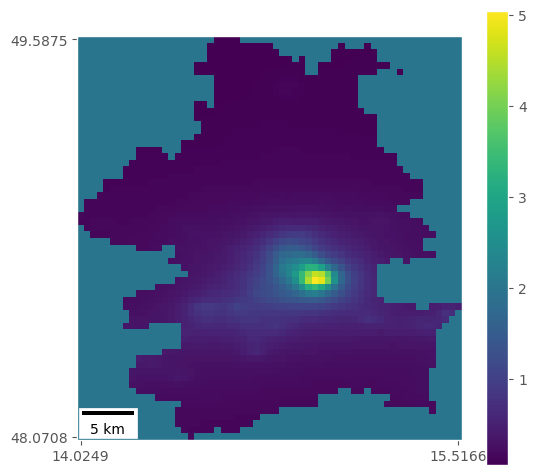

In [178]:
dpi_res = 300

MAP = EAM*NTLI
MAP[MAP==0] = 2

img = MAP
fig, ax = plt.subplots(figsize = (MAP.shape[0]*0.1,MAP.shape[1]*0.1))



im = ax.imshow(img)


X_coords = rounded_coordinates_x
Y_coords = rounded_coordinates_y

ax.set_xticks([0, NTLI.shape[1]-1], [X_coords[0], X_coords[-1]])
ax.set_yticks([0, NTLI.shape[0]-1], [Y_coords[-1], Y_coords[0]])
ax.add_artist(ScaleBar(617.8991644,location='lower left'))


#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(im, cax=cax,ticks=[0, np.max(img)])

plt.grid(False)
plt.imshow(MAP)
plt.colorbar()
plt.show()


fig.savefig('../figures/fig02roi.png', format='png', dpi=dpi_res,bbox_inches="tight")

##nsres=926.63896835
##ewres=617.8991644

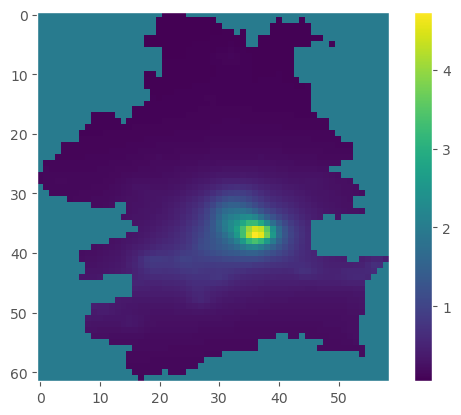

 W = i*a^(p)
r: 0
0.0
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [46. 51.  6. 56. 56. 21. 57. 33. 18. 41.]

 Objective function:
 0.18802005666179233


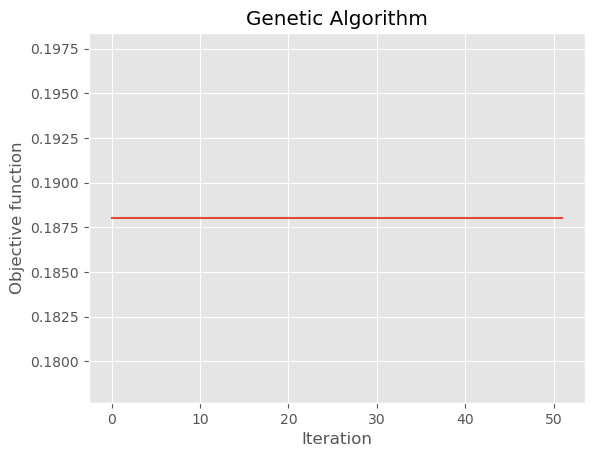

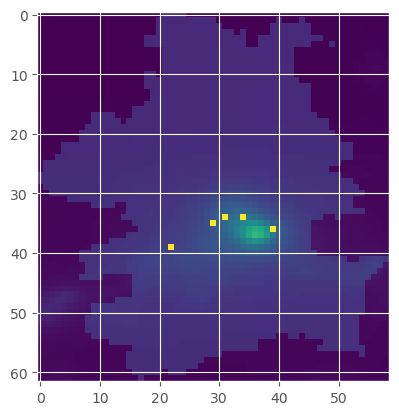

0.25
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [54. 15. 10. 34. 57.  7. 32. 53. 36.  3.]

 Objective function:
 0.19645752954469164


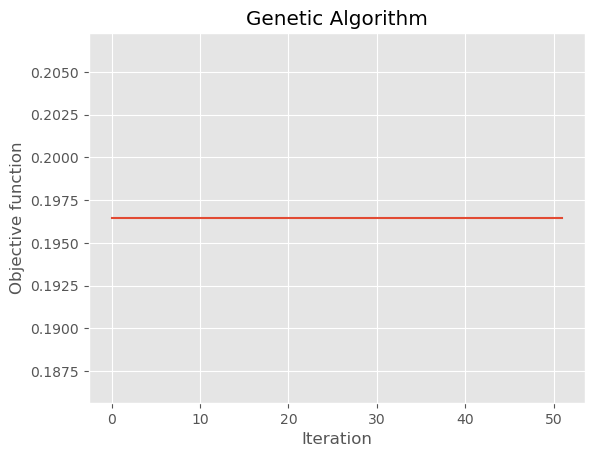

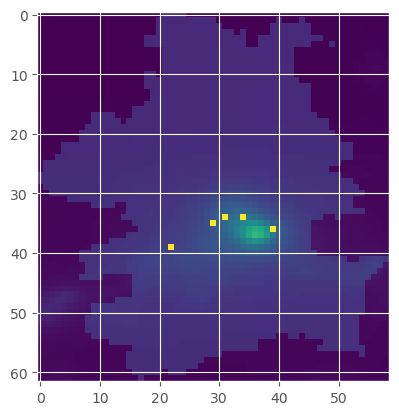

0.5
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [12.  1. 46. 24. 47. 28. 24. 19. 59. 24.]

 Objective function:
 0.2045472564531316


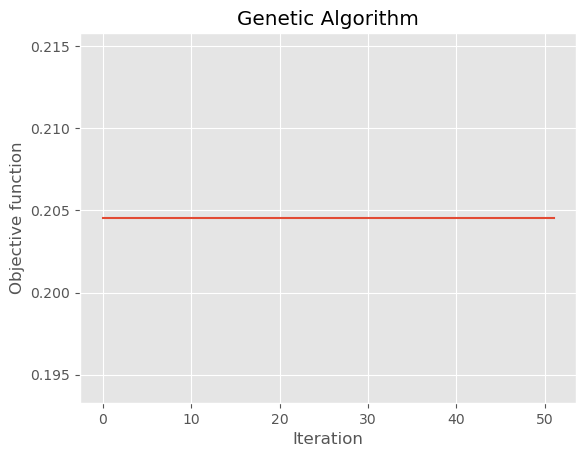

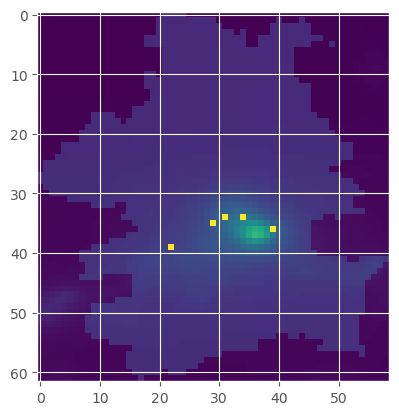

0.75
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [ 9. 20. 19. 44. 22.  2.  2. 44. 45. 44.]

 Objective function:
 0.21232898843587744


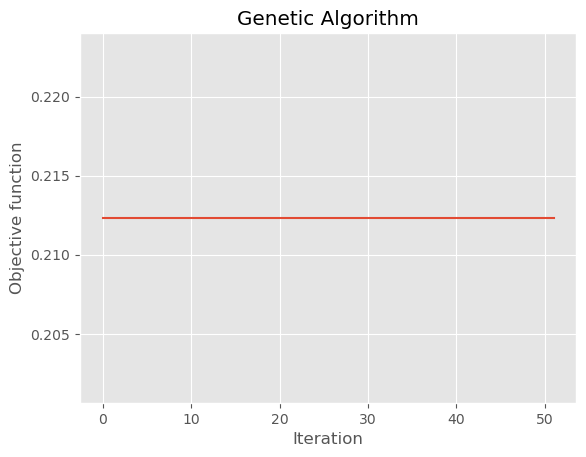

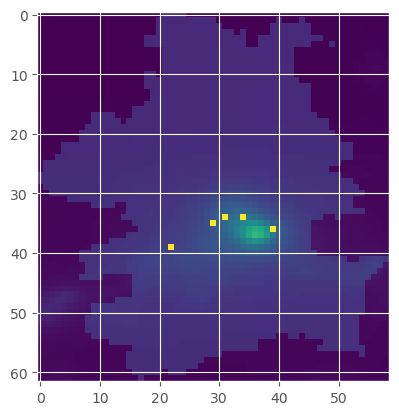

1.0
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [ 4. 37. 50. 25. 53. 42. 42. 55. 12. 45.]

 Objective function:
 0.21983543512796744


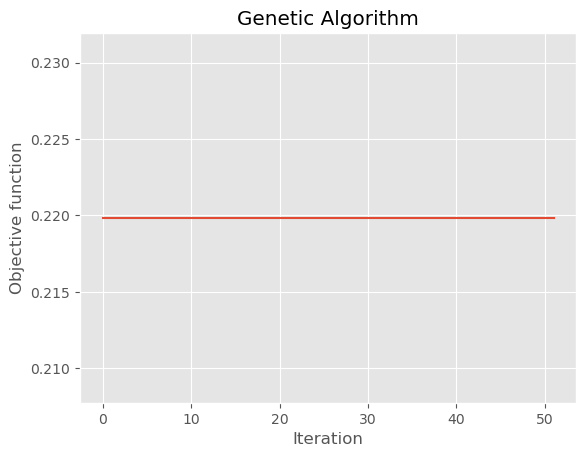

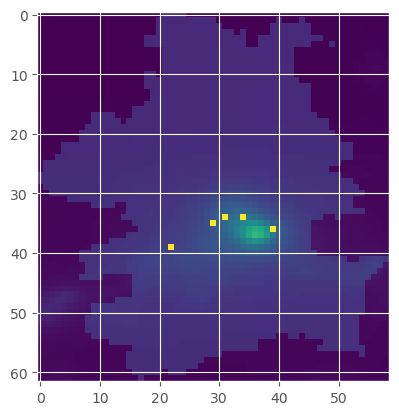

r: 1
0.0
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [31. 58. 48. 33.  9. 34. 36. 36. 33. 44.]

 Objective function:
 0.0016254824071069152


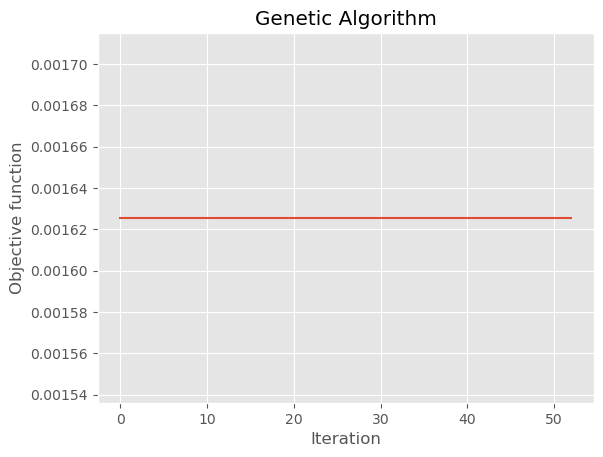

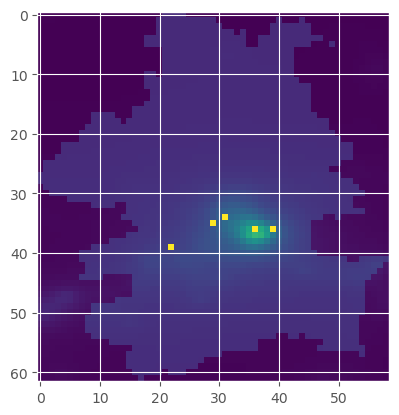

0.25
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [16. 18. 36. 36. 52.  7. 61. 16. 41. 51.]

 Objective function:
 0.09218727757253664


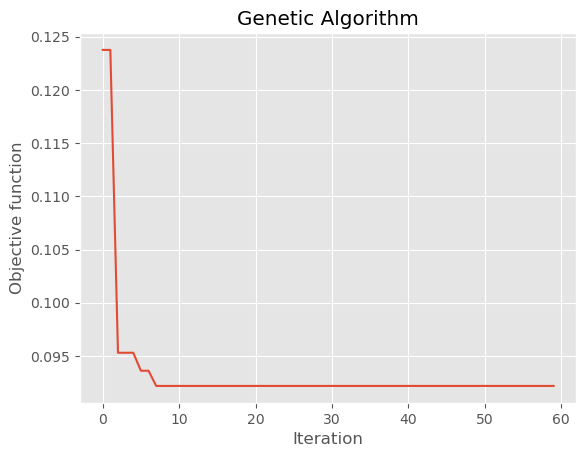

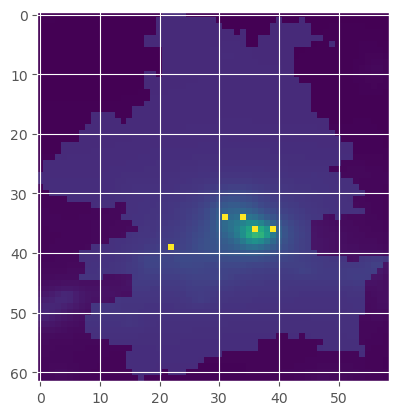

0.5
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [47.  1. 49. 29. 12. 13. 36. 35. 41. 31.]

 Objective function:
 0.12555847347478416


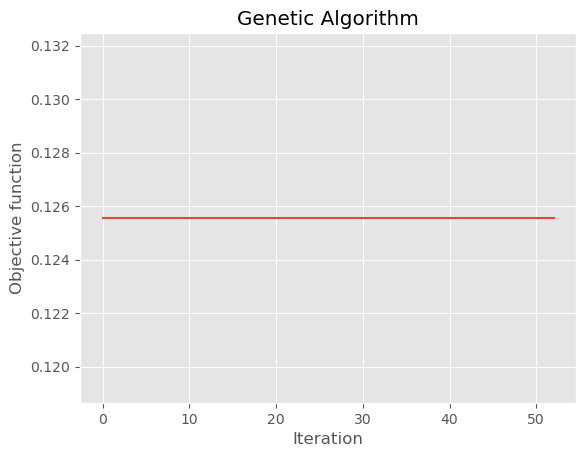

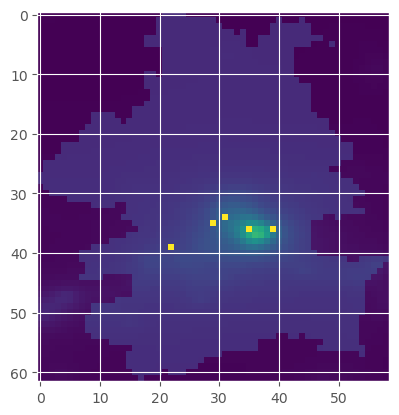

0.75
Selct cost functions: 
 'xor','max' or 'cover'
|_________________________________________________ 2.0% GA is running...

KeyboardInterrupt: 

In [63]:
sensitivity = ps.f5(FDNTLI, EAM, 1)
    
alpha_min = 0
alpha_max = 1

step = 0.05

for r in range(0, 6):   
    
    print("r:", r)
    
    R = list([])
    aptitudes = list([])
    allpositi = list([])

    for a, alpha in enumerate(np.arange(0, 1+0.25, 0.25)):

        alpha = round(alpha, 2)
        
        print(alpha)
        
        aptitude = netfit.NetworkFitness(
            FDNTLI,
            EAM,
            sensitivity,
            variograms,
            variograms_m,
            coords,
            network,
            int(r),
            0.00,
            alpha = alpha

        )


        model = ga(function = aptitude.J_lambda,
            dimension = len(varbound),
            algorithm_parameters = algorithm_parameters,
            variable_type = 'int',
            variable_boundaries = varbound,
            convergence_curve = True
        )
        
        model.run()
        P = model.output_dict["variable"]
        aptitude.J_lambda(P)
        Pbestcomb = aptitude.bestComb
        R.append(Pbestcomb)
        aptitudes.append(model.output_dict["function"])
        
        positions = Pbestcomb.reshape(-1,2).astype(int) 
        MAP = A+EAM+FDNTLI
        MAP[positions[:, 0], positions[:, 1]] = np.max(MAP)*1.5
        plt.imshow(MAP)
        plt.show()
        
        
    XX = [aptitude.f1(r) for r in R]
    YY = [aptitude.f3(r) for r in R  ]
    DF = pd.DataFrame({"J1": XX, "J2": YY, "aptitudes": aptitudes,"locations": R})
    DF.to_csv( "nr2_"+str(r)+".csv")
    
    
        
        
    
    
    

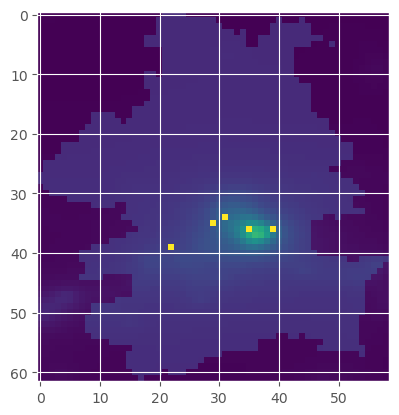

In [64]:
plt.imshow(MAP)

In [ ]:
Xs = np.array(setup["init_fixed_net"]).flatten()


xs = -aptitude.f1(Xs)
ys = -aptitude.f3(Xs)

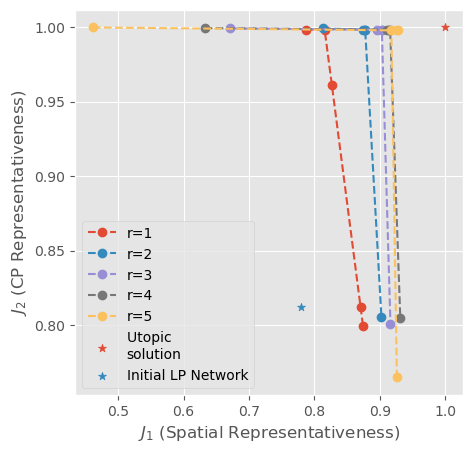

In [ ]:
plt.figure(figsize=(5,5))

#plt.plot([0], [0],'-o')
for r in range(1, 6):
    DF = pd.read_csv( "nr2_"+str(r)+".csv")
    XX = np.array(-DF["J1"])
    YY = np.array(-DF["J2"])
    plt.plot(np.array(XX),np.array(YY),'--o', label = "r={a}".format(a=r))
plt.scatter([[1]], [[1]],marker = "*", label = "Utopic \nsolution")
plt.scatter([xs], [ys],marker = "*", label = "Initial LP Network")
plt.xlabel("$J_1$ (Spatial Representativeness)")
plt.ylabel("$J_2$ (CP Representativeness)")
plt.legend()
plt.show()

In [ ]:
ys

0.8119799433382077

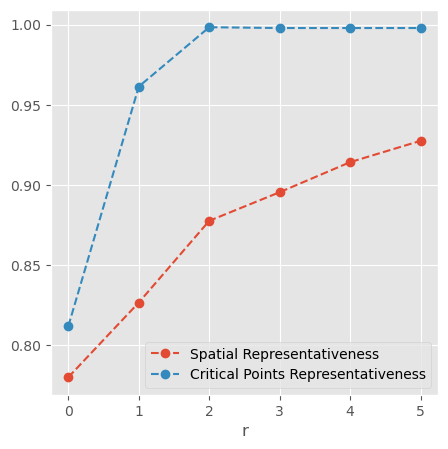

In [ ]:
plt.figure(figsize=(5,5))

#plt.plot([1], [1],'-o')
#plt.plot([0], [0],'-o')
F1 = list([0.7801])
F2 = list([0.81197])

for r in range(1, 6):
    DF = pd.read_csv( "nr2_"+str(r)+".csv")
    XX = np.array(-DF["J1"])
    YY = np.array(-DF["J2"])
    F1.append(XX[2])
    F2.append(YY[2])

plt.plot(np.array([0, 1,2,3,4,5]), F1, '--o', label = "Spatial Representativeness")
plt.plot(np.array([0, 1,2,3,4,5]), F2, '--o', label = "Critical Points Representativeness")

plt.xlabel("r")
plt.legend()
plt.show()

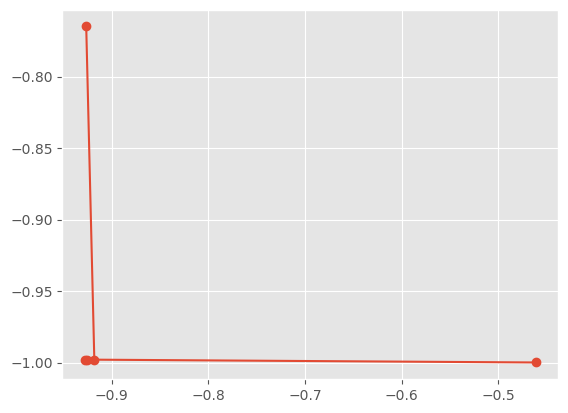

In [ ]:

plt.plot(-np.array(XX),-np.array(YY),'-o')

In [ ]:
YY

array([0.99986426, 0.99786581, 0.99786581, 0.99837452, 0.76491626])

In [ ]:
alphas = np.arange(0, 1 + 0.25, 0.25)

([d**(0.5) for i,d in enumerate((np.array(XX)+1)**2 + (np.array(YY)+1)**2)])

[2.4768506572938405,
 2.7749455493979402,
 2.7761211383880635,
 2.7697165552543477,
 2.612475688301586]

 W = i*a^(p)
Selct cost functions: 
 'xor','max' or 'cover'
 The best solution found:                                                                           
 [35. 16.  1. 26.  7. 48.  4. 45. 22.  7.]

 Objective function:
 0


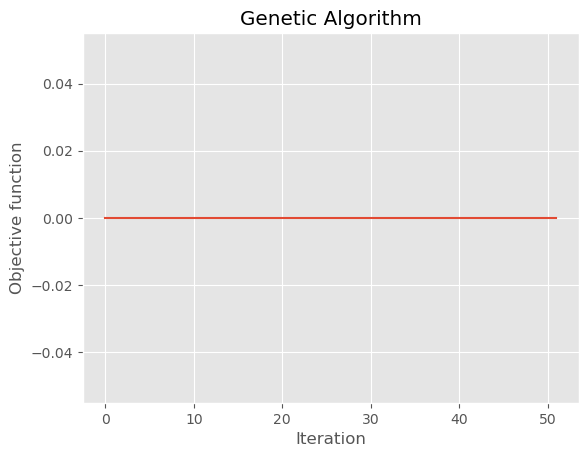

AttributeError: 'NetworkFitness' object has no attribute 'bestComb'

In [ ]:


sensitivity = ps.f5(FDNTLI, EAM, 1)
    
alpha_min = 0
alpha_max = 1

step = 0.1

for r in range(1, 6):
    
    
    R = list([])
    aptitudes = list([])
    allpositi = list([])

    
    for a, alpha in enumerate(np.arange(alpha_min, alpha_max + step, step)):

        #esta variable no se usa

        A = np.zeros(FDNTLI.shape)

        varbound = np.array([[0, NTLI.shape[0]-1], [0, NTLI.shape[1]-1]]*n_sensors)

        c = 2

        aptitude.th = 0.99

        for r in range(1, 2):

            aptitude = netfit.NetworkFitness(FDNTLI,
                                                 EAM,
                                                 sensitivity,
                                                 variograms,
                                                 variograms_m,
                                                 coords,
                                                 network,
                                                 int(r),
                                                 0.00,
                                                alpha = alpha

                                            )




            model = ga(function = aptitude.J,
                             dimension = len(varbound),
                             algorithm_parameters = algorithm_parameters,
                             variable_type = 'int',
                             variable_boundaries = varbound,
                             convergence_curve = True)



        model.run()
        P = model.output_dict["variable"]
        aptitude.J(P)
        Pbestcomb = aptitude.bestComb 
        R.append(Pbestcomb)
        aptitudes.append(model.output_dict["function"])



        #positions = (model.output_dict["variable"].reshape(-1,2)).astype(int)
        positions = Pbestcomb.reshape(-1,2).astype(int) 

        allpositi.append(positions.flatten())

        DF = pd.DataFrame({"J1": XX, "J2": YY, "aptitudes": aptitudes,"locations": allpositi})
        DF.to_csv( "nr"+str(a)+".csv")

        MAP = A+EAM+FDNTLI
        MAP[positions[:, 0], positions[:, 1]] = np.max(MAP)*1.5
        plt.title(alpha)
        plt.imshow(MAP)
        plt.show()




In [79]:
DF = pd.DataFrame({"J1": XX, "J2": YY, "aptitudes": aptitudes,"locations": allpositi})
DF.to_csv( "nr"+str(a)+".csv")

ValueError: All arrays must be of the same length

In [80]:
aptitudes

[-1.0]

In [46]:
init_fixed_net: [[39, 22], [35, 29], [34, 31], [34, 34], [36, 39]]

In [69]:
positions[:, 0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [65]:
positions = Pbestcomb.reshape(-1,2).astype(int) 
MAP = A+EAM+FDNTLI
MAP[positions[:, 0], positions[:, 1]] = np.max(MAP)*1.5

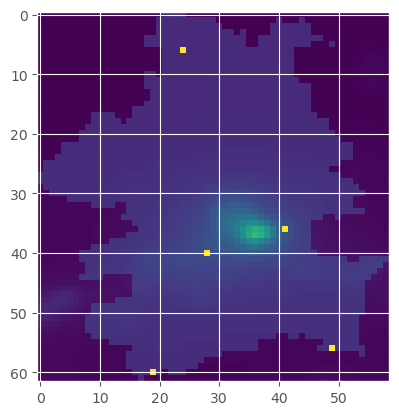

In [66]:
plt.imshow(MAP)

In [118]:
XX = [aptitude.f1(r) for r in R  ]
YY = [aptitude.f3(r) for r in R  ]


In [121]:
YY

[1.0,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9978658114768281,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.9983745175928931,
 0.78335620654006]

Text(0, 0.5, 'Position Measurements/ sum of the highests level of light pollution')

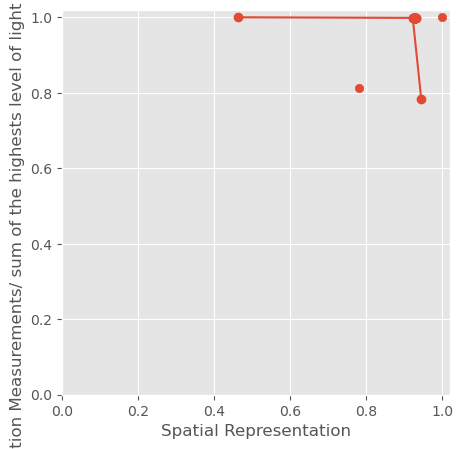

In [119]:
plt.figure(figsize=(5,5))
plt.plot(np.array(XX),YY,'-o')
plt.scatter([Xini, 1],[Yini, 1])
plt.xlim(0, 1+0.02)
plt.ylim(0, 1+0.02)
plt.xlabel("Spatial Representation")
plt.ylabel("Position Measurements/ sum of the highests level of light pollution")

In [113]:
Xi = np.array(setup["init_fixed_net"]).flatten()
Xini = aptitude.f1(Xi)
Yini = aptitude.f3(Xi)

0.7801645648720326

In [115]:
#DF = pd.DataFrame({"J1": XX, "J2": YY, "locations": allpositi})
#DF.to_csv("r6.csv")

Text(0, 0.5, 'Position Measurements/ sum of the highests level of light pollution')

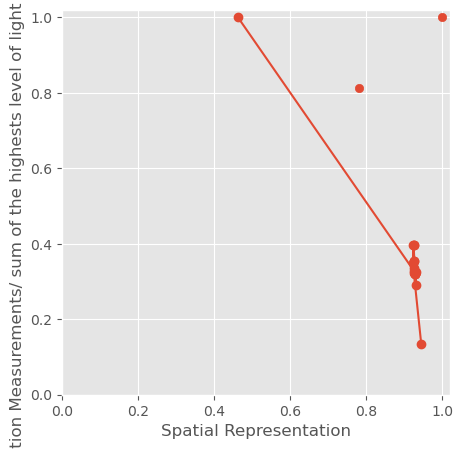

In [116]:
plt.figure(figsize=(5,5))
plt.plot(np.array(XX),YY,'-o')
plt.scatter([Xini, 1],[Yini, 1])
plt.xlim(0, 1+0.02)
plt.ylim(0, 1+0.02)
plt.xlabel("Spatial Representation")
plt.ylabel("Position Measurements/ sum of the highests level of light pollution")

Text(0, 0.5, 'Position Measurements/ sum of the highests level of light pollution')

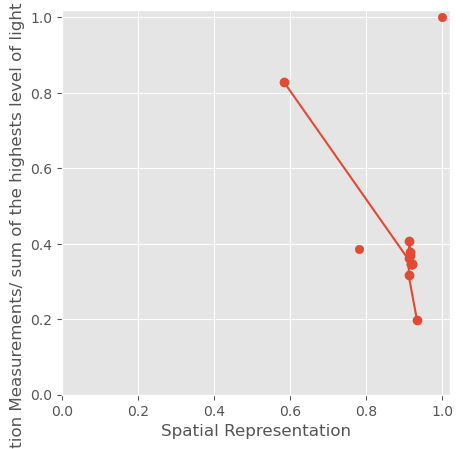

In [63]:
plt.figure(figsize=(5,5))
plt.plot(np.array(XX),YY,'-o')
plt.scatter([Xini, 1],[Yini, 1])
plt.xlim(0, 1+0.02)
plt.ylim(0, 1+0.02)
plt.xlabel("Spatial Representation")
plt.ylabel("Position Measurements/ sum of the highests level of light pollution")


In [57]:
aptitudes

[-0.9996600506685562,
 -0.9886263785260063,
 -0.9790306812820531,
 -0.9691301003922326,
 -0.9593819613253457,
 -0.950753148331813,
 -0.9412288744795971,
 -0.9301375441246851,
 -0.9221803267751651,
 -0.912656052922949,
 -0.9174188284018036]

In [64]:
d = {"f1": XX, "f2": YY, "aptitudes": aptitudes}
pareto = pd.DataFrame(data = d)
pareto.to_csv("r1.csv")

In [44]:
plt.figure(figsize=(5,5))
plt.plot(YY, '-o')
plt.plot(XX, '-o')
#plt.xticks(np.arange(0,len(alpha)), alphas, rotation='vertical')



NameError: name 'YY' is not defined

<Figure size 500x500 with 0 Axes>

In [27]:
alphas = np.arange(0, 1 + 0.01, 0.01)

([d**(0.5) for i,d in enumerate((np.array(XX)-1)**2 + (np.array(YY)-1)**2)])

[0.398148411751352,
 0.5832460174181447,
 0.5832460174181447,
 0.5832460174181447,
 0.5832460174181447,
 0.5832460174181447,
 0.5832460174181447,
 0.5832460174181447,
 0.5832460174181447,
 0.5832460174181447,
 0.7685747926737473]

In [718]:
XX

[0.5746826793994687,
 0.5738042608763643,
 0.5358134240209778,
 0.5344633233983137,
 0.3358883416460929,
 0.19600628574804557,
 0.03348131928513853,
 0.03348131928513853,
 0.03348131928513853,
 0.03348131928513853,
 0.03348131928513853]

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_5854/4087262846.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('afmhot', 256)


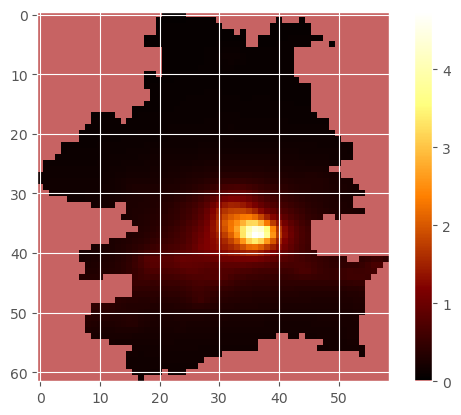

In [719]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


viridis = cm.get_cmap('afmhot', 256)
newcolors = viridis(np.linspace(0, 1, 256))
gray = np.array([200/256, 100/256, 100/256, 1])
newcolors[:1, :] = gray
newcmp = ListedColormap(newcolors)

#plt.imshow(FDNTLI*EAM, cmap=newcmp, rasterized=True, vmin=np.min(FDNTLI*EAM), vmax=np.max(FDNTLI*EAM))


fig, ax1 = plt.subplots(ncols=1)
LP = ax1.imshow(FDNTLI*EAM,  cmap=newcmp, rasterized=True, vmin=np.min(FDNTLI*EAM)-0, vmax=np.max(FDNTLI*EAM))
fig.colorbar(LP, ax=ax1)



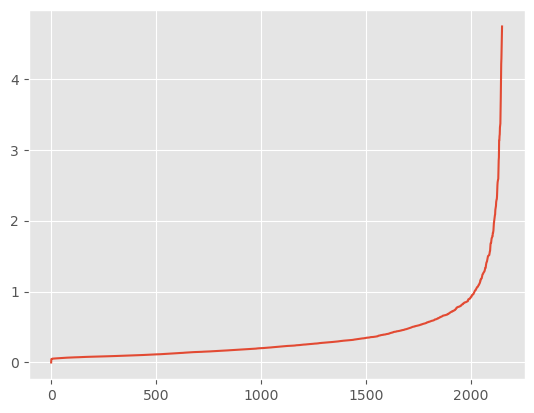

In [720]:
plt.plot(np.unique(FDNTLI*EAM))

In [721]:
R

[array([33, 24, 41, 44, 31, 41, 44, 27, 44, 18]),
 array([41, 27, 31, 41, 41, 44, 32, 25, 44, 18]),
 array([35, 22, 44, 27,  6, 40, 36, 36, 41, 44]),
 array([44, 27, 36, 36, 41, 44, 31, 41, 33, 23]),
 array([33, 24, 37, 37, 37, 36, 36, 36, 46, 26]),
 array([32, 25, 36, 36, 37, 37, 37, 36, 36, 37]),
 array([37, 36, 37, 37, 36, 36, 36, 37, 37, 35]),
 array([37, 37, 37, 36, 36, 36, 37, 35, 36, 37]),
 array([36, 36, 37, 36, 36, 37, 37, 37, 37, 35]),
 array([37, 36, 37, 37, 36, 36, 37, 35, 36, 37]),
 array([36, 36, 36, 37, 37, 36, 37, 37, 37, 35])]

NameError: name 'newcmp' is not defined

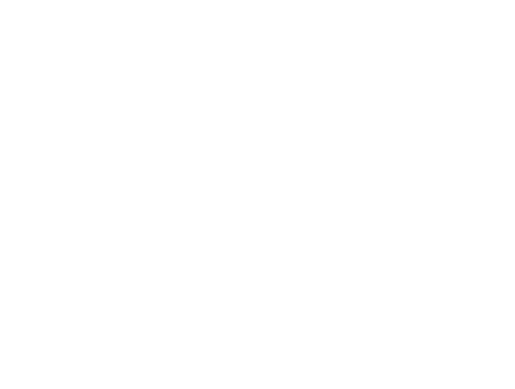

In [46]:


#fig, axs = plt.subplots(2, 3, figsize=(15, 15))

#fig, ax1 = plt.subplots(ncols=1)


for i ,p in enumerate(R):
    

    #q_p = np.array([np.random.randint(ub[1]) for ub in varbound])
    A = np.zeros(FDNTLI.shape)

    #positions = network.reshape(-1, 2)
    #A[positions[:, 0], positions[:, 1]] = 1

    positions = p.reshape(-1, 2)
    
    MAP = A+EAM+FDNTLI
    
    MAP[positions[:, 0], positions[:, 1]] = np.max(MAP)*1.5

    #plt.imshow(MAP)
    
    #axs[int(i/3), i%3 ].grid(False)
    #axs[int(i/3), i%3 ].axis("off")
    #axs[int(i/3), i%3 ].imshow(MAP)
    #axs[int(i/3), i%3 ].title.set_text($$i$$)
    
    outside = (EAM==0)
    MAP[outside] = 0
    fig, ax1 = plt.subplots(ncols=1)
    ax1.grid(False)
    ax1.axis("off")
    
    MAP = np.copy(FDNTLI*EAM)
    MAP[positions[:, 0], positions[:, 1]] = np.max(MAP)*1000
    MAP[positions[:, 0]+1, positions[:, 1]] = np.min(MAP)+1
    MAP[positions[:, 0]-1, positions[:, 1]] = np.min(MAP)+1
    MAP[positions[:, 0], positions[:, 1]+1] = np.min(MAP)+1
    MAP[positions[:, 0], positions[:, 1]-1] = np.min(MAP)+1
    LP = ax1.imshow(MAP,  cmap=newcmp, rasterized=True, vmin=np.min(FDNTLI*EAM)-0, vmax=np.max(FDNTLI*EAM))
    #fig.colorbar(LP, ax=ax1)
    #ax = isns.imgplot(MAP, dx=1000, units="m", cmap = "tab10")

    plt.savefig("positions_red_"+str(c)+"_"+str(i)+".eps")
    #plt.show()

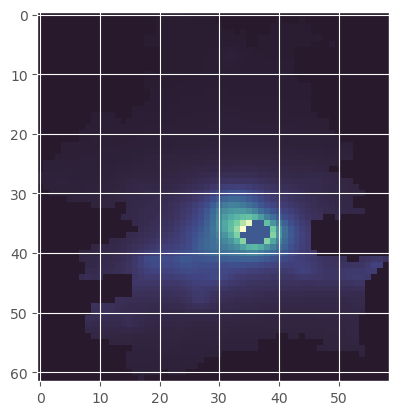

In [723]:
plt.imshow(MAP)

In [724]:
positions = [[44, 18],
       [44, 18],
       [41, 44],
       [34, 23],
       [ 9, 38]]

In [725]:
C2 = aptitude.getCapturedLightPollutionCovers(positions)

In [726]:
n = len(positions)

n_avg = 0
for c in range(1, n + 1):
    
    #mascara del terrotorio que abarca el sensor c
    one_cover_mask = np.argmax(C2, axis = 0) == c
    
    
    #print(np.sum(one_cover_mask))
    
    if np.sum(one_cover_mask) == 0:
    
        avg_lp = 0
    
    else:
        
        
       
        one_cover_values = np.max(C2, axis = 0)
        sum_values = np.sum(one_cover_values*one_cover_mask)
        avg_lp = sum_values/np.sum(one_cover_mask)
        
    print(avg_lp)
    n_avg += avg_lp/n

0.34189517707455286
0
0.36901281801567437
0.21496007179566196
0.17494415589362097


In [727]:
np.sum([0.34189517707455286, 0, 0.36901281801567437, 0.21496007179566196, 0.17494415589362097])/5

0.220162444555902

In [728]:
n_avg

0.22016244455590203

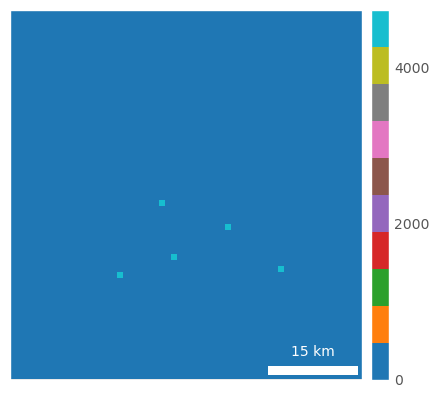

In [699]:
import seaborn_image as isns



ax = isns.imgplot(MAP, dx=1000, units="m", cmap = "tab10")

In [700]:
tuple(R[0].reshape(-1,2)[0])


(39, 28)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


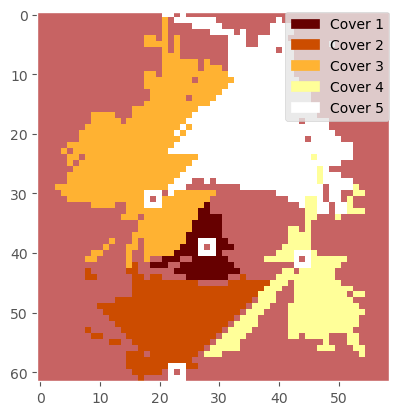

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


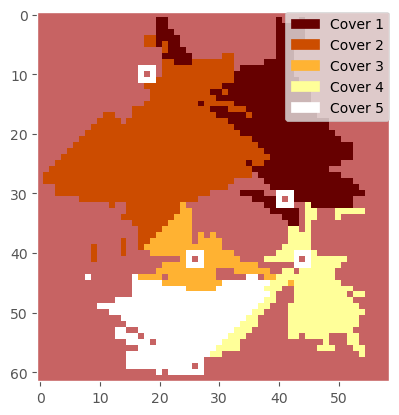

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


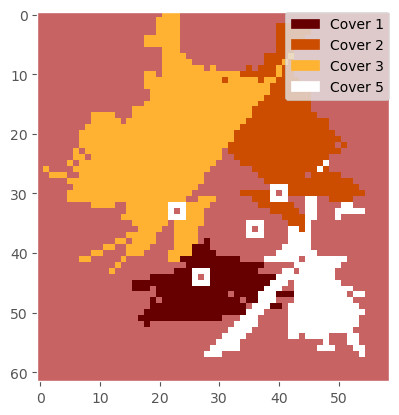

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


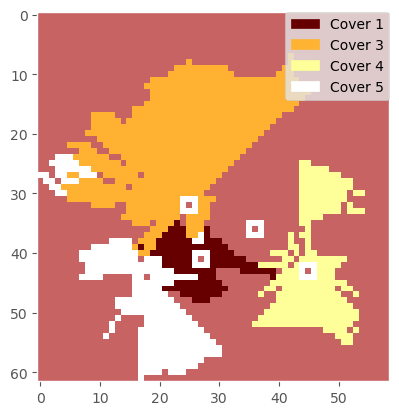

In [701]:
import matplotlib.patches as mpatches

for i in range(len(R)):
    
    P = R[i].reshape(-1, 2)
    C = aptitude.getCapturedLightPollutionCovers(P)
    regionCover = np.argmax(C, axis = 0)
    regionCover[P[:,0],P[:,1]] = np.min(regionCover)
    
    regionCover[P[:,0]-1, P[:,1]] = np.max(regionCover)
    regionCover[P[:,0]+1, P[:,1]] = np.max(regionCover)
    regionCover[P[:,0],P[:,1]+1] = np.max(regionCover)
    regionCover[P[:,0],P[:,1]-1] = np.max(regionCover)
    regionCover[P[:,0]+1,P[:,1]+1] = np.max(regionCover)
    regionCover[P[:,0]+1,P[:,1]-1] = np.max(regionCover)
    regionCover[P[:,0]-1,P[:,1]+1] = np.max(regionCover)
    regionCover[P[:,0]-1,P[:,1]-1] = np.max(regionCover)
    
    im = plt.imshow(regionCover, interpolation='none', cmap = newcmp)
    values = np.unique(regionCover.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="Cover {l}".format(l=values[i]) ) for i in range(1,len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.00, 1), loc=0, borderaxespad=0.)

    plt.grid(False)
    plt.savefig("covers_red_"+str(c)+"_"+str(i)+".eps", dpi = 300)
    plt.show()

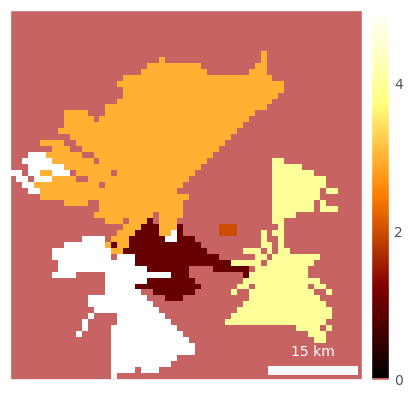

In [704]:



ax = isns.imgplot(np.argmax(C, axis = 0), dx=1, units="km", cmap = newcmp)

In [703]:
FDNTLI.shape

L = np.ones((62,59,5))
#taken r
r = 0

for i in range(5):
    
    #experimento 0
    #sensor 
    P = tuple(R[r].reshape(-1,2)[i])

    L[:, :, i] =  (C==(i+1))*FDNTLI*EAM

ValueError: could not broadcast input array from shape (6,62,59) into shape (62,59)

(array([322.,  95.,  20.,  15.,  19.,  15.,   6.,   3.,   2.,   2.]),
 array([-0.60403427, -0.42603558, -0.24803689, -0.07003819,  0.1079605 ,
         0.2859592 ,  0.46395789,  0.64195659,  0.81995528,  0.99795398,
         1.17595267]),
 <BarContainer object of 10 artists>)

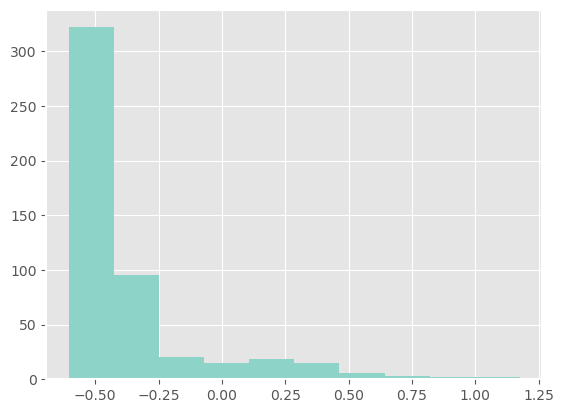

In [942]:
region = L[:,:,0].flatten()
P = tuple(R[r].reshape(-1,2)[0])


plt.hist(region[region>0]-FDNTLI[P])



(array([3159.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         499.]),
 array([0.        , 0.06513008, 0.13026016, 0.19539024, 0.26052032,
        0.32565039, 0.39078047, 0.45591055, 0.52104063, 0.58617071,
        0.65130079]),
 <BarContainer object of 10 artists>)

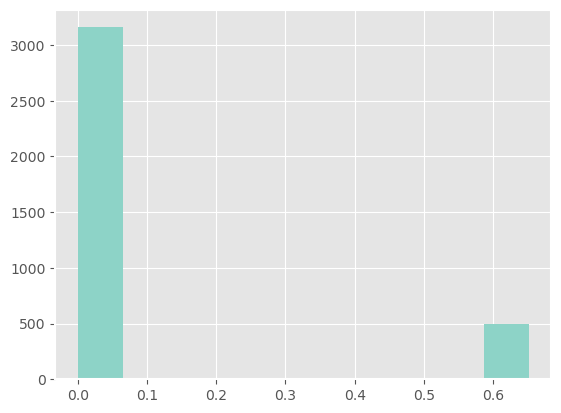

In [924]:
plt.hist(L[:,:,0].flatten() )

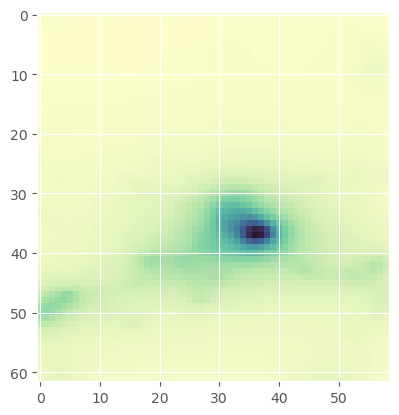

In [188]:
#E; estimation
E = np.max(L, axis = 2)

plt.imshow((E-FDNTLI))

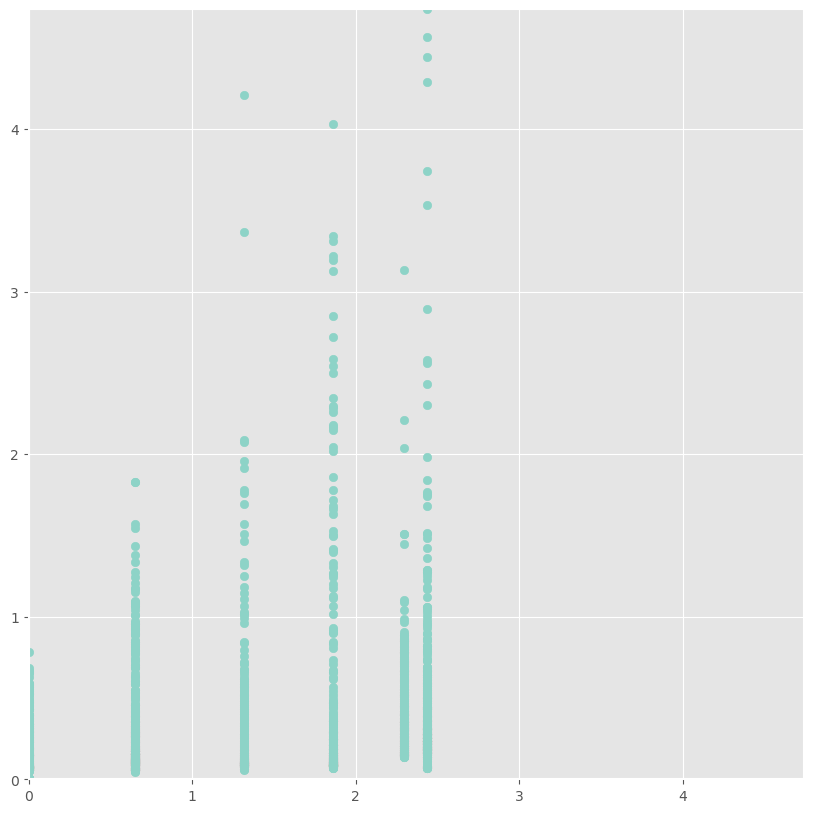

In [914]:
X = (EAM*E).flatten()
Y = (EAM*FDNTLI).flatten()
plt.figure(figsize=(10, 10))

plt.ylim(0, np.max(Y))
plt.xlim(0, np.max(Y))

plt.scatter(X, Y)

In [846]:
r = 0




C = (np.argmax(aptitude.getCapturedLightPollutionCovers(R[r].reshape(-1,2)), axis = 0))


In [848]:
tuple(R[0].reshape(-1,2)[1])

(35, 29)

In [943]:
plt.imshow((C==2)*(L-FDNTLI))

ValueError: operands could not be broadcast together with shapes (62,59,5) (62,59) 

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_29889/182319964.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data, palette="tab10", linewidth = 2.5)


<Axes: >

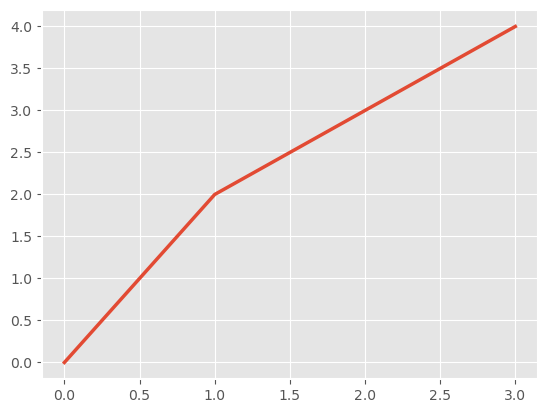

In [762]:
import seaborn as sns
data = [0, 2, 3, 4]
sns.lineplot(data, palette="tab10", linewidth = 2.5)

In [498]:
C = (np.argmax(aptitude.getCapturedLightPollutionCovers(R[-1].reshape(-1,2)), axis = 0))



In [499]:
covers =  aptitude.getCapturedLightPollutionCovers(R[-1].reshape(-1,2))[2]



In [500]:
ix = R[-1].reshape(-1,2)

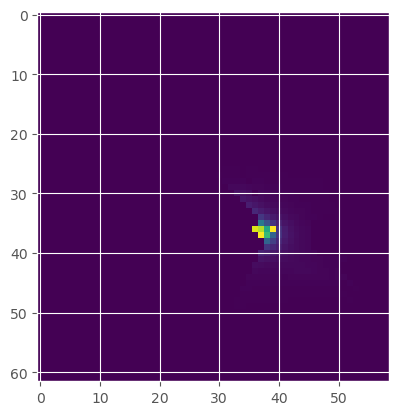

In [501]:
covers[tuple(ix[1])] = np.max(covers)

plt.imshow(covers)

In [502]:
np.max(covers)

20.641400672132228

In [503]:
p = R[-1].reshape(-1,2)
E = np.zeros(C.shape)

C[p[:, 0], p[:,1]] = 10

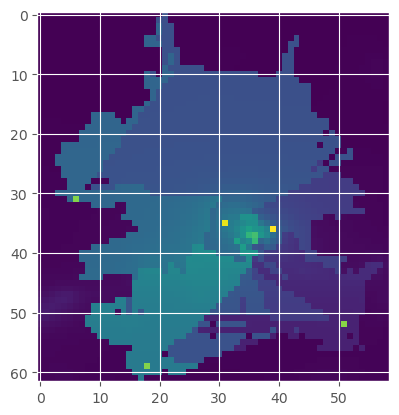

In [504]:
plt.imshow(C+E+FDNTLI)

In [505]:
p[:, 0]

array([52, 36, 35, 31, 59])

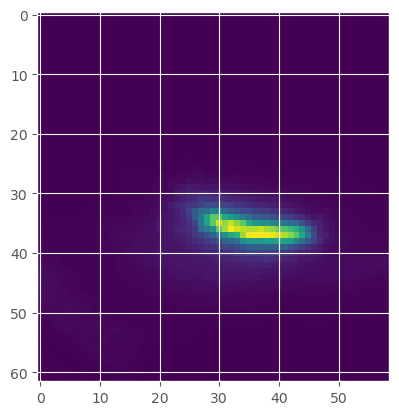

In [506]:
ix = 50

plt.imshow(variograms[ix])

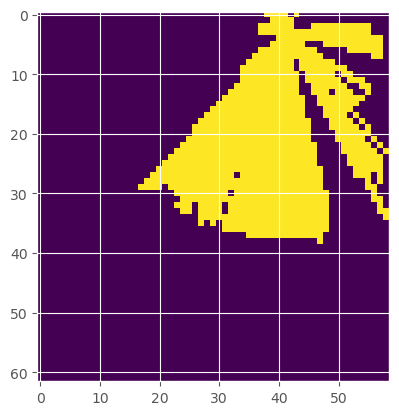

In [507]:


plt.imshow(variograms_m[ix])

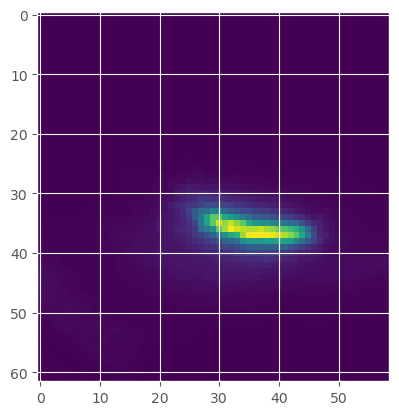

In [508]:
plt.imshow(variograms[ix])

In [509]:
print(np.max(variograms[ix]))
(np.min(variograms[ix]))

3.4066042293364194


0.0

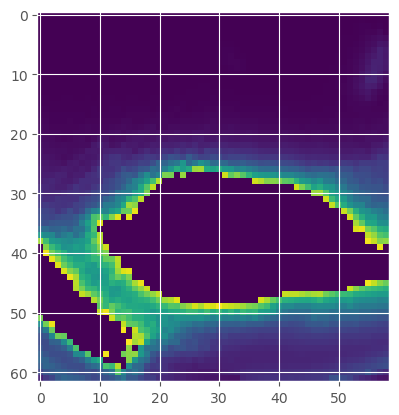

In [510]:
plt.imshow(variograms[ix] * (variograms[ix]>0) * (variograms[ix]<0.05)*1)

Referencias:
    
    https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

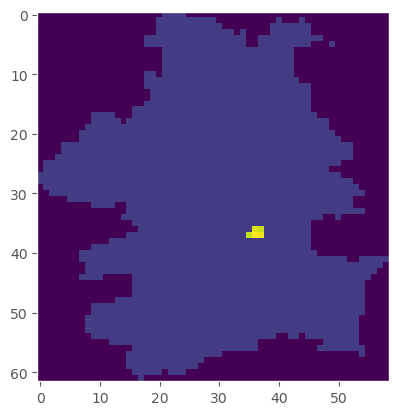

In [179]:
np.sort(FDNTLI.flatten())[-5:]
plt.imshow(EAM+FDNTLI*(FDNTLI>=4.2089896))
plt.grid(False)

array([4.2089896, 4.2878604, 4.442038 , 4.5638757, 4.7373123],
      dtype=float32)

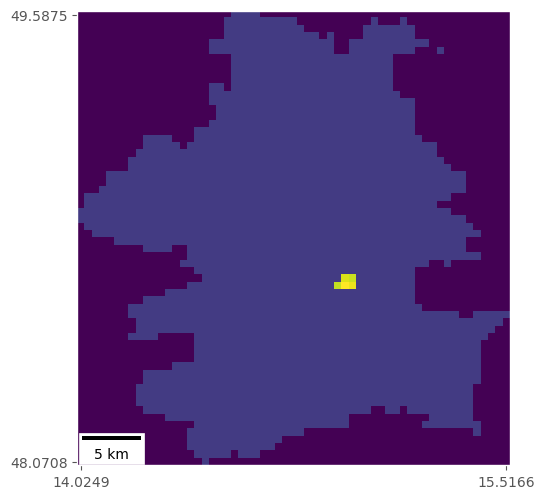

In [211]:
dpi_res = 300

MAP = EAM*NTLI
MAP[MAP==0] = 2



img = MAP
fig, ax = plt.subplots(figsize = (MAP.shape[0]*0.1,MAP.shape[1]*0.1))


img = EAM+FDNTLI*(FDNTLI>=4.2089896)

im = ax.imshow(img)



X_coords = rounded_coordinates_x
Y_coords = rounded_coordinates_y

ax.set_xticks([0, NTLI.shape[1]-1], [X_coords[0], X_coords[-1]])
ax.set_yticks([0, NTLI.shape[0]-1], [Y_coords[-1], Y_coords[0]])
ax.add_artist(ScaleBar(617.8991644,location='lower left'))

plt.grid(False)


plt.grid(False)


           
#plt.show()

fig.savefig('../figures/fig03CP.png', format='png', dpi=dpi_res,bbox_inches="tight")
